In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import gpflow
import gpflux

from gpflow.config import default_float

tf.keras.backend.set_floatx("float64")

In [2]:
%pwd

'/Users/felix/Py/CoDaS/GPFlux/GPflux'

In [3]:
air = np.loadtxt('airline.csv')

x = air[: ,0]
y = air[:, 1]
stop = 96

from sklearn import preprocessing
import random

random.seed(23)

idx = random.sample(range(len(x)), 50)

x_new = (x - min(x))/(max(x)-min(x))

scaler = preprocessing.StandardScaler().fit(y.reshape(-1,1))

y_new = scaler.transform(y.reshape(-1,1))


#train_gx = x_new[idx][:,None]
#train_gy = y_new[idx] + 0.0001 * np.random.normal(0,1,50)[:,None]

train_x = x_new[:stop][:,None]
train_y = y_new[:stop]

test_x = x_new[stop:][:,None]
test_y = y_new[stop:]

In [4]:
#d = np.load("tests/snelson1d.npz")
#X, Y = data = d["X"], d["Y"]
#X = (X - X.mean()) / X.std()
num_data, input_dim = train_x.shape

In [6]:
num_data = len(train_x)
num_inducing = 23
output_dim = train_y.shape[1]

kernel = gpflow.kernels.SquaredExponential()
inducing_variable = gpflow.inducing_variables.InducingPoints(
    np.linspace(train_x.min(), train_y.max(), num_inducing).reshape(-1, 1)
)
gp_layer = gpflux.layers.GPLayer(
    kernel, inducing_variable, num_data=num_data, num_latent_gps=output_dim
)

In [7]:
likelihood = gpflow.likelihoods.Gaussian(0.001)

# So that Keras can track the likelihood variance, we need to provide the likelihood as part of a "dummy" layer:
likelihood_container = gpflux.layers.TrackableLayer()
likelihood_container.likelihood = likelihood

model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(1, activation="linear"),
        gp_layer,
        likelihood_container,  # no-op, for discovering trainable likelihood parameters
    ]
)
loss = gpflux.losses.LikelihoodLoss(likelihood)

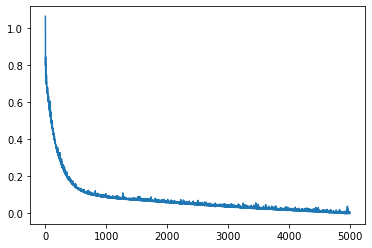

In [11]:
model.compile(loss=loss, optimizer="adam")
hist = model.fit(train_x, train_y, epochs=5000, verbose=0)
plt.plot(hist.history["loss"])

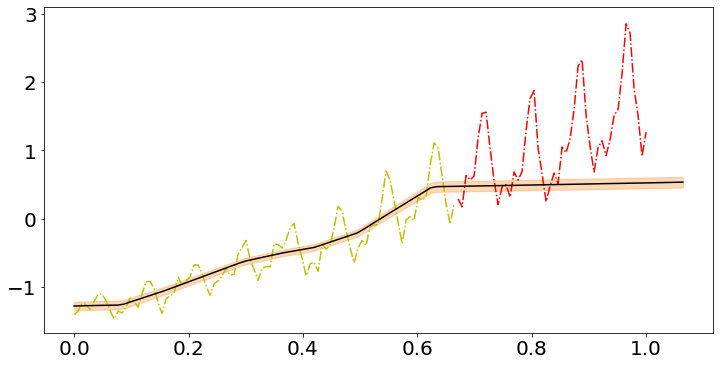

In [24]:
import matplotlib 

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

def plot(model, X, Y, test_x, test_y, figname, ax=None):
    if ax is None:
        #fig, ax = plt.subplots()
        fig, ax = plt.subplots(figsize=(12, 6))
    

    x_margin = 0.4
    N_test = 100
    X_test = np.linspace(X.min() , X.max() + x_margin, N_test).reshape(-1, 1)
    f_distribution = model(X_test)

    mean = f_distribution.mean().numpy().squeeze()
    var = f_distribution.variance().numpy().squeeze()
    X_test = X_test.squeeze()
    lower = mean - 2 * np.sqrt(var)
    upper = mean + 2 * np.sqrt(var)

    ax.set_ylim(Y.min() - 0.2, Y.max() + 2.0)
    ax.plot(X, Y, "y-.", linewidth=1.5)
    ax.plot(test_x, test_y, "r-.", linewidth=1.5)
    ax.plot(X_test, mean, 'k-', linewidth=1.5)

    ax.fill_between(X_test, lower, upper, color="C1", alpha=0.3)
    fig.savefig(figname, bbox_inches='tight')


plot(model, train_x, train_y, test_x, test_y, 'dkl_airline.pdf')